# **PSD UTS "Prediksi Produksi Penjualan Ice Cream"**



*   Nama : Zulfa Lailatul Mu'achirin
*   Nim : 220411100147
*   Matkul : PSD D

## Data Understanding

Data diperoleh dari kaggle https://www.kaggle.com/datasets/atharvaarya25/ice-cream-production-over-50-years. Pada data tersebut hanya terdapat 2 fitur yaitu DATE yang menunjukkan tanggal dan IPN31152N yang merupakan fitur produksi penjualan. Pada data ini terdapat 577 data yang dikumpulkan dari 50 tahun terakhir mulai dari tahun 1972. Data yang dikumpulkan merupakan data yang diambil setiap bulan pada tanggal 1 untuk produksi penjualan.

### library

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor # Import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler # Import StandardScaler for scaling
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingRegressor

### menampilkan data

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/kuliah sem 5/PSD/Mydata/ice_cream.xlsx")
df['DATE'] = pd.to_datetime(df['DATE'])

# Set DATE as index
df.set_index('DATE', inplace=True)
df

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636
...,...
2019-09-01,100.1741
2019-10-01,90.1684
2019-11-01,79.7223


## Data Preprocessing

### menambahkan fitur

menambahkan fitur month untuk memberikan perhitungan di setiap bulannya

In [ ]:
# We'll use a supervised learning approach: predicting the next value based on previous values
df['Month'] = np.arange(len(df))  # Adding a month counter
df

,IPN31152N,Month
DATE,,
1972-01-01,59.9622,0
1972-02-01,67.0605,1
1972-03-01,74.2350,2
1972-04-01,78.1120,3
1972-05-01,84.7636,4
...,...,...
2019-09-01,100.1741,572
2019-10-01,90.1684,573
2019-11-01,79.7223,574


### missing value

mengecek apakah ada missing value pada data yang dipakai

In [ ]:
missing_values = df.isnull().sum()
print(missing_values)

IPN31152N    0
Month        0
dtype: int64


### deskripsi data

In [ ]:
description = df.describe()
print(description)

        IPN31152N       Month
count  577.000000  577.000000
mean   109.701844  288.000000
std     27.951723  166.709828
min     58.659800    0.000000
25%     88.514900  144.000000
50%    107.461700  288.000000
75%    127.932300  432.000000
max    196.173700  576.000000


## Modeling

### membagi data

Untuk fiturnya kita memakai fitur month serta untuk targetnya kita memakai fitur IPN31152N, kemudian dengan teknik sliding window untuk mengenerate fitur berdasarkan bulan sebelumnya. Untuk window_size nya sendiri adalah 12, karena kita akan memakai 12 bulan untuk prediksi 12 bulan kedepan

In [ ]:
# Features (Months), Target (IPN31152N)
X = df[['Month']]
y = df['IPN31152N']

# Creating a sliding window function to generate features based on previous months
def create_sliding_window_features(df, window_size):
    X, y = [], []
    for i in range(window_size, len(df)):
        X.append(df[i-window_size:i])
        y.append(df[i])
    return np.array(X), np.array(y)

# Set window size to 12 months (can be adjusted)
window_size = 12

# Creating sliding window features for the target variable
X_window, y_window = create_sliding_window_features(df['IPN31152N'].values, window_size)

dari array hasil pada pembuatan fitur dengan sliding window kita akan membagi datanya untuk dijadikan data train dan data test. Dengan data train 80% dan data test 20% tanpa diacak, guna mempertahankan urutan waktunya. Kemudian kita normalisasi dengan standarscaler.

In [ ]:
# Splitting the df into training and test sets
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_window, y_window, test_size=0.2, shuffle=False)

# Scaling features
scaler = StandardScaler()
X_train_w_scaled = scaler.fit_transform(X_train_w)
X_test_w_scaled = scaler.transform(X_test_w)

### membuat model

untuk modeling dengan bagging regressor kita akan menggunakan 3 base model. Dari 3 model tersebut akan menghasilkan masing masing prediksi, kemudian prediksi-prediksi tersebut akan di ambil rata-ratanya dengan menggunakan voting regressor. Voting regressor inilah yang akan digunakan untuk inputan meta predictor bagging. Setelah dilakukan prediksi akan dihitung juga rmse, mse, mae, dan r2 nya. Prediksi 12 bulan kedepan menggunakan teknik sliding window dengan mengisi nilai pada bulan selanjutnya dengan prediksi baru

In [ ]:
# Define the three base models
tree_model = DecisionTreeRegressor()
forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
linear_model = LinearRegression()

# Create a VotingRegressor (acts as the combination of 3 base models)
voting_regressor = VotingRegressor(estimators=[('tree', tree_model), ('forest', forest_model), ('linear', linear_model)])

# Build the Bagging Regressor with the VotingRegressor as the base model
bagging_model_voting = BaggingRegressor(estimator=voting_regressor, n_estimators=100, random_state=42)
bagging_model_voting.fit(X_train_w_scaled, y_train_w)

# Predicting on the test set
y_pred_voting = bagging_model_voting.predict(X_test_w_scaled)

# Calculate performance metrics
rmse_voting = np.sqrt(mean_squared_error(y_test_w, y_pred_voting))
mse_voting = mean_squared_error(y_test_w, y_pred_voting)
mae_voting = mean_absolute_error(y_test_w, y_pred_voting)
r2_voting = r2_score(y_test_w, y_pred_voting)

# Predicting the next 12 months using the ensemble sliding window
last_window = df['IPN31152N'].values[-window_size:]
predictions_voting = []
for _ in range(12):
    last_window_scaled = scaler.transform(last_window.reshape(1, -1))
    next_pred = bagging_model_voting.predict(last_window_scaled)
    predictions_voting.append(next_pred[0])
    # Update the window with the new prediction
    last_window = np.append(last_window[1:], next_pred)



### membuat visualisasi

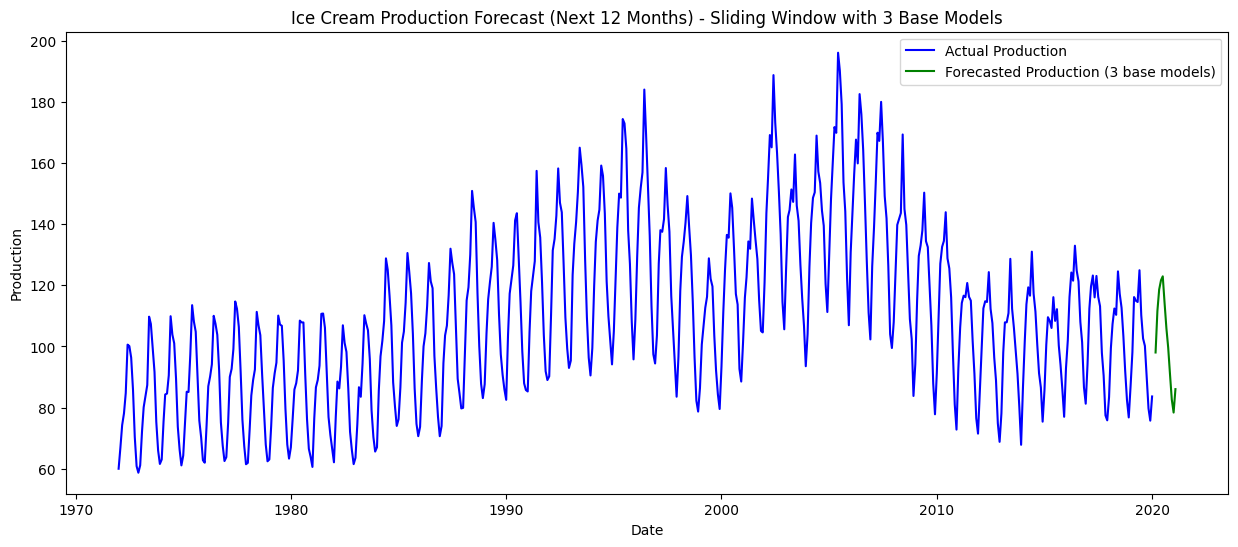

RMSE: 6.196240727928091
MSE: 38.39339915843484
MAE: 5.089241808279032
R^2 Score: 0.8493111713673671


In [ ]:
# Plotting the actual vs predicted values with the sliding window approach (3 base models)
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['IPN31152N'], label='Actual Production', color='blue')
plt.plot(pd.date_range(start=df.index[-1], periods=13, freq='ME')[1:], predictions_voting, label='Forecasted Production (3 base models)', color='green')
plt.title('Ice Cream Production Forecast (Next 12 Months) - Sliding Window with 3 Base Models')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.show()

# rmse_voting, mse_voting, mae_voting, r2_voting, predictions_voting
print("RMSE:", rmse_voting)
print("MSE:", mse_voting)
print("MAE:", mae_voting)
print("R^2 Score:", r2_voting)